## Load the module

In [1]:
import mypy as mp
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
import numpy as np

from scipy.signal import find_peaks
from scipy.interpolate import splrep, splev
from scipy.constants import hbar

import os
import pandas as pd

In [2]:
def normalize_y_01(y):
    min_y, max_y = np.min(y), np.max(y)
    return (y-min_y)/(max_y-min_y), min_y, max_y

def renormalize_y(y, min_y, max_y):
    return y*(max_y-min_y)+min_y

def moving_average(x, ind):
    # moving average without reducing size of x
    xmat =[]
    for i in range(ind):
        xmat.append([x[0]]*i+list(x)+[x[-1]]*(ind-i-1))
    xmat = np.array(xmat)
    x_filt = np.average(xmat,axis=0)[ind//2:-ind+ind//2+1]
    
    return x_filt

def single_photon_power(w_r, w_d, k_in, k_ex, frequency_units=True):
    # Delta = Detuning
    kappa = k_in + k_ex
    Delta = w_d - w_r
    Pin = hbar * w_d * (kappa**2/4 + Delta**2) / k_ex
    if frequency_units:
        return Pin * (2*np.pi)**2
    else:
        return Pin
    
params = {
    'figure.dpi': 300,
    'savefig.dpi': 300, 
    'svg.fonttype': 'none',
    'pdf.fonttype': 42,
    # 'font.family': 'Arial', 
    'font.size': 6,
    'axes.linewidth' : 0.75,         
    'xtick.major.size':2,
    'ytick.major.size':2,    
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'xtick.major.pad': 4,
    'ytick.major.pad': 2,              
    'xtick.labelsize' : 6,
    'ytick.labelsize' : 6,
    'xtick.major.width': 0.75,
    'ytick.major.width': 0.75,
    'xtick.bottom': True,
    'xtick.top': True,
    'ytick.left': True,
    'ytick.right': True,         
    'lines.linewidth': 0.75,  
    'lines.markersize': 2.5,           
    'lines.markeredgewidth': 0.0,
    'legend.frameon': True,
    'legend.numpoints': 1,
    'legend.loc': 'best',
    'legend.fontsize': 6,
    'axes.grid': False,
}
mpl.rcParams.update(params)

In [3]:
def large_vna_scan_analysis(freqs, z, n_peaks, detection_technique, magnify_span, window_num, peak_distance, smoothing_interpolation=15, nbr_std_dev=15, max_nbr_iter=500, plotting=True):
    amp = np.abs(z)
    pha = np.unwrap(np.angle(z))

    npts = len(freqs)
    span = np.max(freqs) - np.min(freqs)
    df = span / npts

    s_re = np.real(z)
    s_im = np.imag(z)

    if detection_technique.lower() == "moving average":
        bkg_re = moving_average(s_re, window_num)
        bkg_im = moving_average(s_im, window_num)
        bkg_z = bkg_re + 1j * bkg_im

        bkg_amp = np.abs(bkg_z)
        bkg_pha = np.unwrap(np.angle(bkg_z))
        normalized_spectrum = np.abs(z-bkg_z)/abs(np.std(z-bkg_z))

        freqs_plot = freqs
    elif detection_technique.lower() == "phase derivative":
        # using phase derivative directly
        phase_derivative = np.abs(np.diff(np.unwrap(np.angle(z))) / np.diff(freqs))

        normalized_spectrum = phase_derivative / np.max(phase_derivative)

        freqs_plot = (freqs[1:] + freqs[:-1]) / 2.0
    elif detection_technique.lower() == "interpolation":
        # using a cleaned version of the vna spectrum (modulus)
        s_re, min_sr, max_sr = normalize_y_01(s_re)
        s_im, min_si, max_si = normalize_y_01(s_im)

        # removing some background based on smoothing_interpolation
        bkg_re = renormalize_y(splev(freqs, splrep(freqs, s_re, s=smoothing_interpolation), der=0), min_sr, max_sr)
        bkg_im = renormalize_y(splev(freqs, splrep(freqs, s_im, s=smoothing_interpolation), der=0), min_si, max_si)
        bkg_z = bkg_re + 1j * bkg_im

        normalized_spectrum = 20*np.abs(np.log10(np.abs(z/bkg_z)))
        normalized_spectrum /= np.max(normalized_spectrum)

        freqs_plot = freqs
    else:
        raise ValueError("Invalid value for detection_technique. Should be one of ['moving average', 'phase derivative', 'interpolation'].")

    spectrum_std = normalized_spectrum.std()
    height_threshold = nbr_std_dev * spectrum_std
    peaks_found = 0
    i = 0
    while peaks_found != n_peaks and i < max_nbr_iter:
        idx_peaks, _ = find_peaks(normalized_spectrum, height=height_threshold, distance=int(peak_distance/df))
        peaks_found = len(idx_peaks)
        if peaks_found > n_peaks:
            height_threshold *= 1.05
        elif peaks_found < n_peaks:
            height_threshold *= 0.9
        i += 1
    print(f"Achieved in {i} iterations.")

    resonant_freqs = np.array([freqs[idx_peak] for idx_peak in idx_peaks])
    resonances = {
        f"R{i}": {
            "freq": freqs[idx_peak],
            "popt": None,
        } for i, idx_peak in enumerate(idx_peaks)
    }

    if plotting:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*6/2.54, 4/2.54))
        ax = axes[0]
        ax.plot(freqs/1e9, 20*np.log10(amp), '-', lw=0.5, label='')
        ax.set_xlabel('Frequency (GHz)')          
        ax.set_ylabel('Abs[S21] (dB)')
        ax = axes[1]
        ax.plot(freqs/1e9, pha, '-', lw=0.5, label='')
        ax.set_xlabel('Frequency (GHz)')          
        ax.set_ylabel('Arg[S21] (rad)')
        fig.tight_layout()

        fig, ax = plt.subplots(figsize=(6/2.54, 4/2.54))
        fig.suptitle("Wide scan")
        ax.plot(freqs_plot / 1e9, normalized_spectrum)
        ax.axhline(height_threshold, linestyle="--", color="r", label=f"Threshold @ {np.round(height_threshold / spectrum_std, 2)} std dev")
        ax.scatter(resonant_freqs / 1e9, [normalized_spectrum[idx_peak] for idx_peak in idx_peaks], color="r")
        ax.set_xlabel('Frequency (GHz)')
        if detection_technique.lower() == "moving average":
            ax.set_ylabel(r'$|S_{21} / $std$(S_{21})|$ (arb. units)')
        elif detection_technique.lower() == "phase derivative":
            ax.set_ylabel(r'$\frac{d}{df}$(Arg[$S_{21}$]) (arb. units)')
        elif detection_technique.lower() == "interpolation":
            ax.set_ylabel('|$S_{21}$| (arb. units)')
        ax.legend()
        fig.tight_layout()

        res_freqs = []
        for j, idx_peak in enumerate(idx_peaks):
            res_freqs.append(freqs[idx_peak])
            
            npts_magnify = int(npts * magnify_span / span)
            freqs_magnify = freqs[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)]/1e9
            print(f"{j}: {np.min(freqs_magnify)} ~ {np.max(freqs_magnify)}")
            
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3*6/2.54, 4/2.54))
            fig.suptitle("R" + str(j) + " with idx: "+str(idx_peak) + "/" + str(npts))
            ax = axes[0]
            ax.plot(freqs[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)]/1e9, 20*np.log10(amp[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)]), '.-', lw=0.5, label='')
            if detection_technique.lower() == "moving average":
                ax.plot(freqs[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)]/1e9, 20*np.log10(bkg_amp[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)]), '-', lw=1)
            ax.set_xlabel('Frequency (GHz)')          
            ax.set_ylabel('Abs[S21] (dB)')
            ax = axes[1]
            ax.plot(freqs[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)]/1e9, pha[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)], '.-', lw=0.5, label='')
            if detection_technique.lower() == "moving average":
                ax.plot(freqs[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)]/1e9, bkg_pha[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)], '.-', lw=0.5, label='')
            ax.set_xlabel('Frequency (GHz)')          
            ax.set_ylabel('Arg[S21] (rad)')
            ax = axes[2]
            ax.plot(freqs_plot[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)]/1e9, normalized_spectrum[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)], '.-', lw=0.5, label='')
            ax.set_xlabel('Frequency (GHz)')          
            ax.set_ylabel(r'$\frac{d}{df}$(Arg[$S_{21}$]) (arb. units)')
            fig.tight_layout()

    print("We found", len(idx_peaks), "peaks.")
    return resonances

def small_vna_scan_analysis(datasets, resonances, modify_dict, use_no_fano_with_amp, plotting=True, freq_m_est=1.5e6, Gamma_m_est=0.1, g_0_est=10):
    for j, label in enumerate(list(resonances.keys())):
        # dataset = datasets_spectro[label]
        print('================ ' + label +' ====================')
        resonance = resonances[label]
        data = datasets[label]
        
        freqs = data["freqs"]
        z = data["z"]
        
        amps, phases = np.abs(z), np.unwrap(np.angle(z))
        z_avg = z # np.average(z, axis=0)
        amps_avg, phases_avg = np.abs(z_avg), np.unwrap(np.angle(z_avg))
        
        # avg_phase = np.mean(phases_avg)
        # phases -= avg_phase
        # phases_avg -= avg_phase

        if use_no_fano_with_amp:
            try:
                popt, perr, zfit, zini = mp.S11exp_fit_no_fano_with_amp(freqs, amps_avg, phases_avg)
                amp_normalisation = popt[-1]
            except Exception as e:
                print(e)
                amp_normalisation = 1
        else:
            popt, perr, zfit, zini = mp.Lorentzian_fit(freqs, amps_avg ** 2, ini=False)
            offset_amps = np.sqrt(popt[3])
            # offset_amps = mp.get_offset(amps_avg)
            
            if np.isnan(offset_amps):
                offset_amps = np.mean(amps)

            amps /= offset_amps
            amps_avg /= offset_amps

            amp_normalisation = 1
            try:
                # f0,kex,kin,phi,tau,x0,y0
                popt, perr, zfit, zini = mp.S11exp_fit(freqs, amps_avg, phases_avg)
            except:
                pass
        
        try:
            poptc, perrc = mp.popt_correct(popt, perr, print_on=False)

            amf = np.absolute(zfit)
            phf = np.angle(zfit)
            phf = np.unwrap(phf)
            phf -= np.floor((np.average(phf)+np.pi)/(2*np.pi))*2*np.pi

            ami = np.absolute(zini)
            phi = np.angle(zini)
            phi = np.unwrap(phi)
            phi -= np.floor((np.average(phi)+np.pi)/(2*np.pi))*2*np.pi
            
            w_r = poptc[0]
            k_ex = poptc[1]
            k_in = poptc[2]
            w_d = w_r
            # single photon power on resonance
            P_1 = single_photon_power(w_r, w_d, k_in, k_ex, frequency_units=True)
            P_1_dBm = 10*np.log10(P_1/1e-3)
            print('w_r/2pi  =', w_r/1e9, '+/-', perrc[0]/1e9, 'GHz')
            print('k_ex/2pi =', k_ex/1e3, '+/-', perrc[1]/1e3, 'kHz')
            print('k_in/2pi =', k_in/1e3, '+/-', perrc[2]/1e3, 'kHz')
            std_dev_power = w_r/k_in*np.sqrt((perrc[0]/w_r)**2+(perrc[2]/k_in)**2)
            print('Q =', round(w_r/k_in/1e6, 3), '+/-', round(std_dev_power/1e6, 3), 'M')
            print('Single photon power =', round(P_1_dBm, 1), 'dBm')
            print('SNR =', (np.mean(amps_avg) / np.std(amps_avg))**2)
            
            if modify_dict:
                resonance["popt"] = popt
                resonance["freq"] = w_r
                resonance["k_in"] = k_in
                resonance["k_ex"] = k_ex
                resonance["k_in+k_ex"] = k_in + k_ex
                resonance["single_photon_power"] = round(P_1_dBm, 1)

                resonance["freq_m"] = None
                resonance["Gamma_m"] = None
                resonance["g_0"] = None
                resonance["freq_m_est"]  = freq_m_est
                resonance["Gamma_m_est"] = Gamma_m_est
                resonance["g_0_est"]     = g_0_est
                
                resonance["power_PI"] = None
        except:
            pass

        if plotting:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*6/2.54, 4/2.54))
            fig.suptitle(label + " small scan ")
            
            ax = axes[0]
            # for i in range(avg):
            #     ax.plot(freqs/1e9, amps[i]/amp_normalisation, '-', lw=0.25, alpha=0.25)
            ax.plot(freqs/1e9, amps_avg/amp_normalisation, 'b.', lw=0.5)
            try:
                ax.plot(freqs/1e9, ami/amp_normalisation, 'g-', lw=0.5,alpha=0.5)
                ax.plot(freqs/1e9, amf/amp_normalisation, 'r-', lw=0.5)
            except:
                pass
            ax.set_xlabel('Frequency (GHz)')          
            ax.set_ylabel(r'abs[$S_{21}$]')

            ax.set_ylim(0, 1.1*np.max(amps)/amp_normalisation)

            ax = axes[1]
            # for i in range(avg):
            #     ax.plot(freqs/1e9, phases[i], '-', lw=0.25, alpha=0.25)
            ax.plot(freqs/1e9, phases_avg, 'b.', lw=0.5)
            try:
                ax.plot(freqs/1e9, phi, 'g-', lw=0.5,alpha=0.5)
                ax.plot(freqs/1e9, phf, 'r-', lw=0.5)
            except:
                pass
            ax.set_xlabel('Frequency (GHz)')
            ax.set_ylabel(r'arg[$S_{21}$] (rad)')
            fig.tight_layout()
            plt.show()
    return resonances

## Load data

In [4]:
# data_folder = "./data_20250406/"
data_folder = '/home/lesnow/PalaceForCQED/examples/data_v8/driven'

data_dict = {
    name: pd.read_csv(os.path.join(data_folder, name, "port-S.csv"))
    for name in os.listdir(data_folder)
    if os.path.isdir(os.path.join(data_folder, name)) 
    and os.path.exists(os.path.join(data_folder, name, "port-S.csv"))
}

## Wide Scan

In [5]:
# load the full scan data to generate the resonances list
# df = data_dict["lumped_7.0-7.8_Step0.001_2025-04-03T024135"]

df = data_dict["lumped_7.0-7.8_Step0.001_2025-04-03T024135"]

freqs = df['         f (GHz)'].to_numpy()
amp = 10**(df['          |S[1][1]| (dB)'].to_numpy() / 20)
pha_deg = df['     arg(S[1][1]) (deg.)'].to_numpy()

freqs = freqs*1e9
pha = np.deg2rad(pha_deg)
z = amp*np.exp(1j*pha)

Achieved in 17 iterations.
0: 7.188 ~ 7.197
1: 7.281 ~ 7.29
2: 7.555 ~ 7.564
3: 7.65 ~ 7.659
We found 4 peaks.


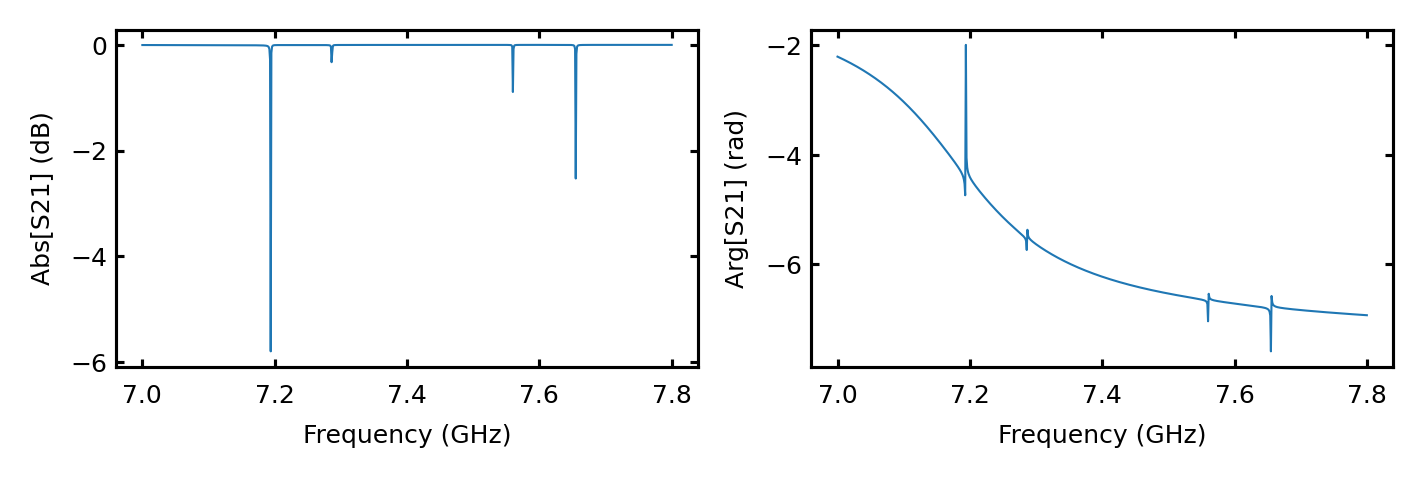

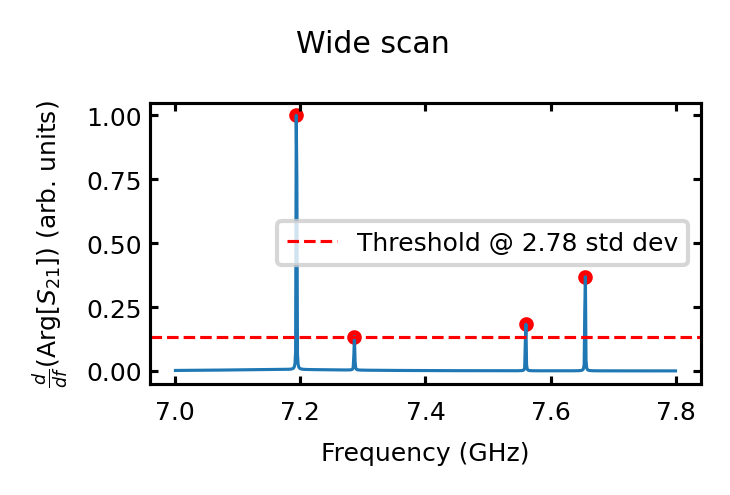

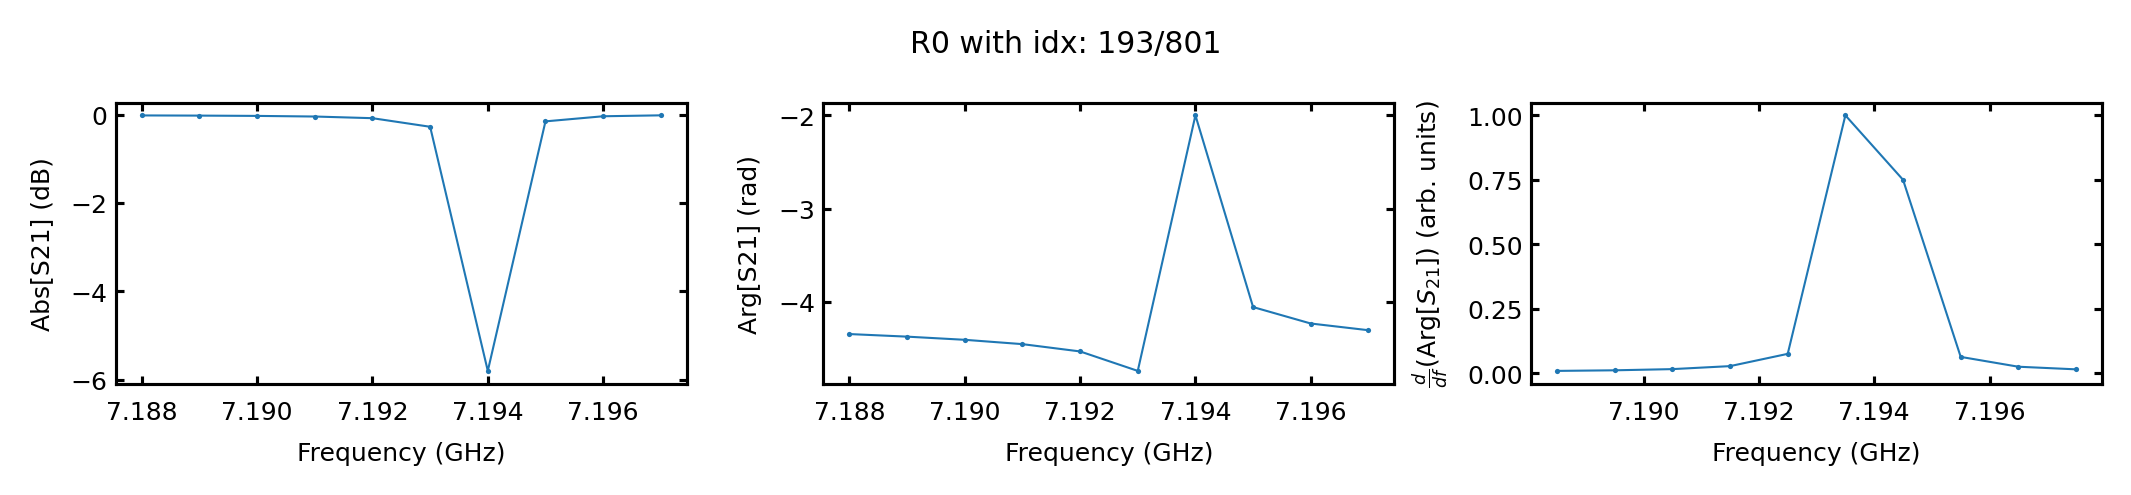

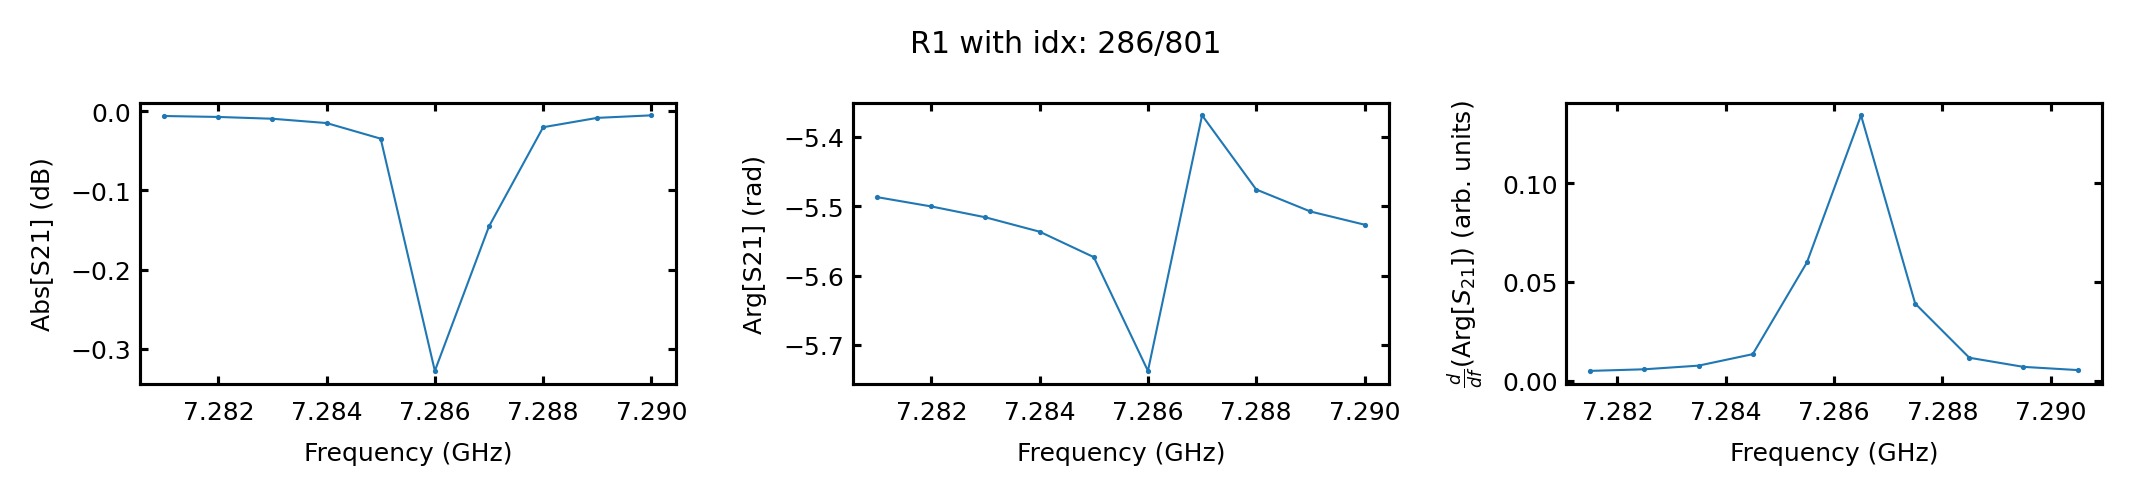

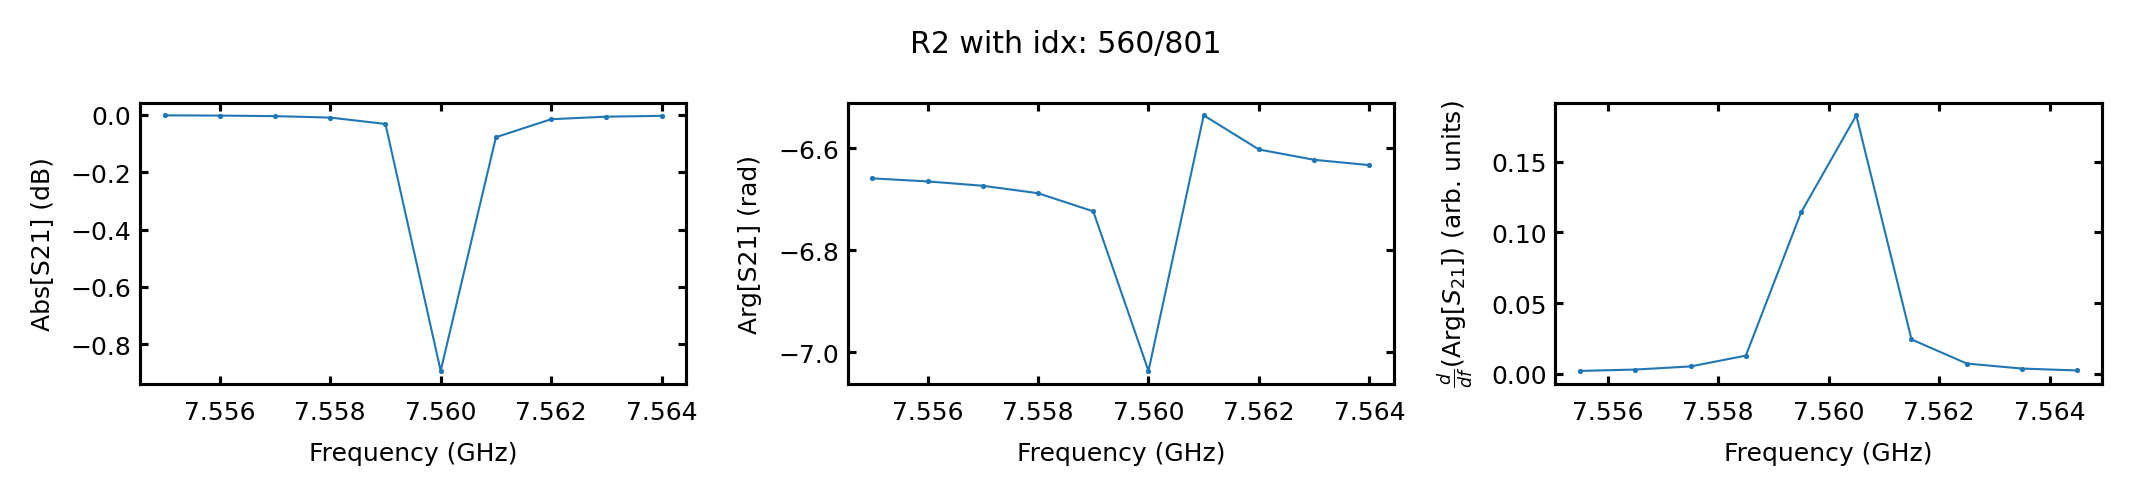

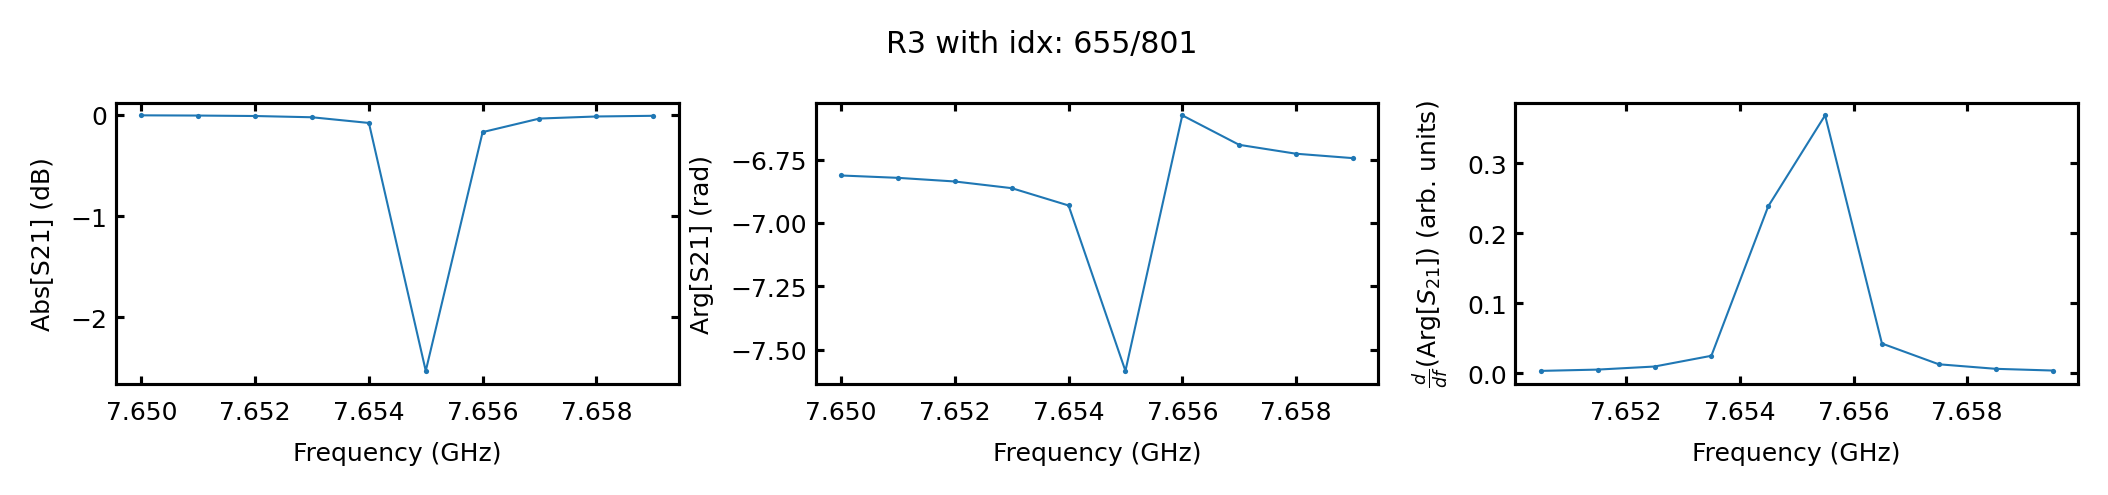

In [6]:
########################################################################
##############################  Analysis  ##############################
########################################################################
n_peaks = 4
detection_technique = "phase derivative" # one of ["moving average", "phase derivative", "interpolation"]
smoothing_interpolation = 15
nbr_std_dev = 15
max_nbr_iter = 500
window_num = 10 # smoothing, needs to be adjusted to account for linewidth & total npts/span (smaller for smaller linewidth)
magnify_span = 10e6
peak_distance = 10e6 # Hz minimum distance between peaks
plotting = True

resonances = large_vna_scan_analysis(freqs, z, n_peaks, detection_technique, magnify_span, window_num, peak_distance, smoothing_interpolation=smoothing_interpolation, nbr_std_dev=nbr_std_dev, max_nbr_iter=max_nbr_iter, plotting=plotting)

## Small Scan

In [7]:
##! extract the small scan data from full scan data if no small scan data is available
# smallscan_window_Hz = 20e6  # +/- 10 MHz window for extraction

# dataset_smallscan = {
#     label: {
#         "freqs": freqs[(freqs > res["freq"] - smallscan_window_Hz) & (freqs < res["freq"] + smallscan_window_Hz)],
#         "z":     z[(freqs > res["freq"] - smallscan_window_Hz) & (freqs < res["freq"] + smallscan_window_Hz)],
#     }
#     for label, res in resonances.items()
# }

# load the small scan data accordingly
dataset_smallscan = {}

smallscan_name_list = ["lumped_7.188-7.198_Step2.0e-5_2025-04-07T150716",
                       "lumped_7.281-7.291_Step2.0e-5_2025-04-07T163548",
                       "lumped_7.555-7.565_Step2.0e-5_2025-04-07T180244",
                       "lumped_7.65-7.66_Step2.0e-5_2025-04-07T192842",]

for idx, label in enumerate(resonances.keys()):
    print(label)
    df = data_dict[smallscan_name_list[idx]]
    freqs = df['         f (GHz)'].to_numpy()
    amp = 10**(df['          |S[1][1]| (dB)'].to_numpy() / 20)
    pha_deg = df['     arg(S[1][1]) (deg.)'].to_numpy()

    freqs = freqs*1e9
    pha = np.deg2rad(pha_deg)
    z = amp*np.exp(1j*pha)

    dataset_smallscan[label] = {
        "freqs": freqs,
        "z":     z,
    }

R0
R1
R2
R3


================ R0 ====================
w_r/2pi  = 7.1933261 +/- 6e-07 GHz
k_ex/2pi = 360.0 +/- 10.0 kHz
k_in/2pi = 134.0 +/- 6.0 kHz
Q = 0.054 +/- 0.002 M
Single photon power = -142.9 dBm
SNR = 112.95425164676931


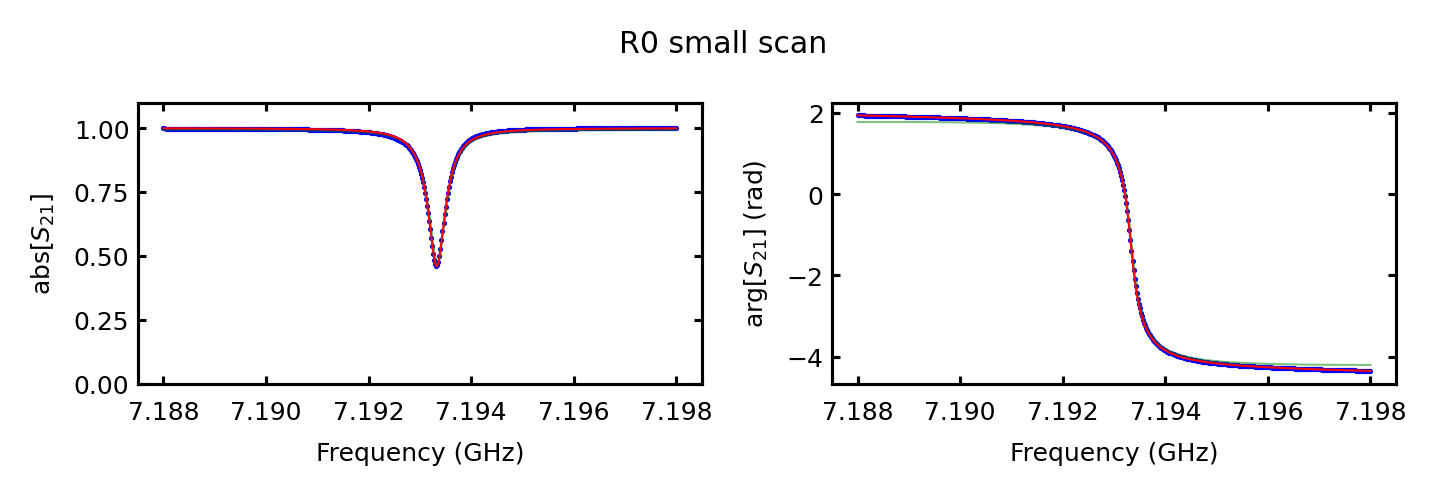

================ R1 ====================
w_r/2pi  = 7.2861432 +/- 1e-07 GHz
k_ex/2pi = 96.0 +/- 0.2 kHz
k_in/2pi = 133.4 +/- 0.3 kHz
Q = 0.055 +/- 0.0 M
Single photon power = -143.8 dBm
SNR = 118.79700709902336


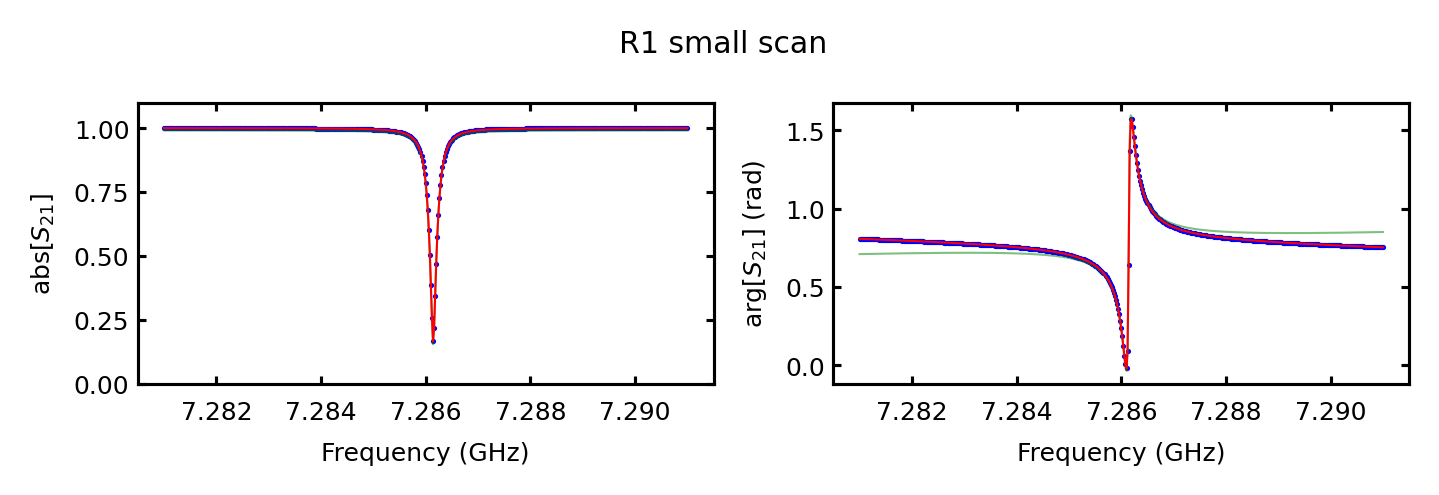

================ R2 ====================
w_r/2pi  = 7.56043547 +/- 1e-08 GHz
k_ex/2pi = 91.45 +/- 0.02 kHz
k_in/2pi = 119.71 +/- 0.03 kHz
Q = 0.063 +/- 0.0 M
Single photon power = -144.2 dBm
SNR = 123.72990542021658


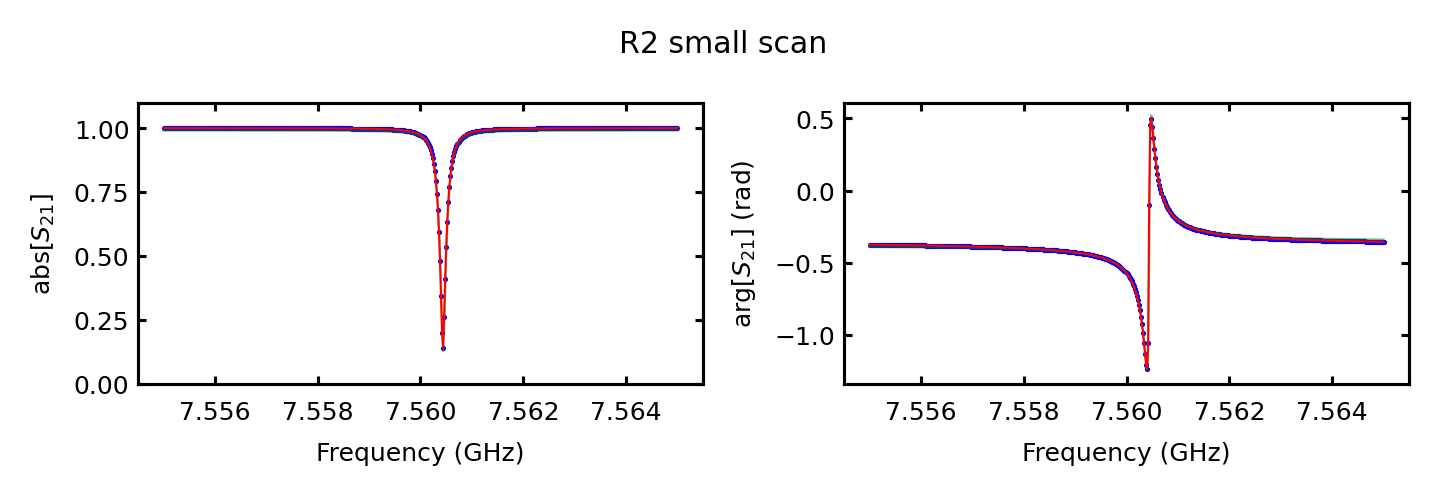

================ R3 ====================
w_r/2pi  = 7.65505649 +/- 7e-08 GHz
k_ex/2pi = 174.0 +/- 1.0 kHz
k_in/2pi = 150.0 +/- 1.0 kHz
Q = 0.051 +/- 0.0 M
Single photon power = -143.2 dBm
SNR = 75.72367207490365


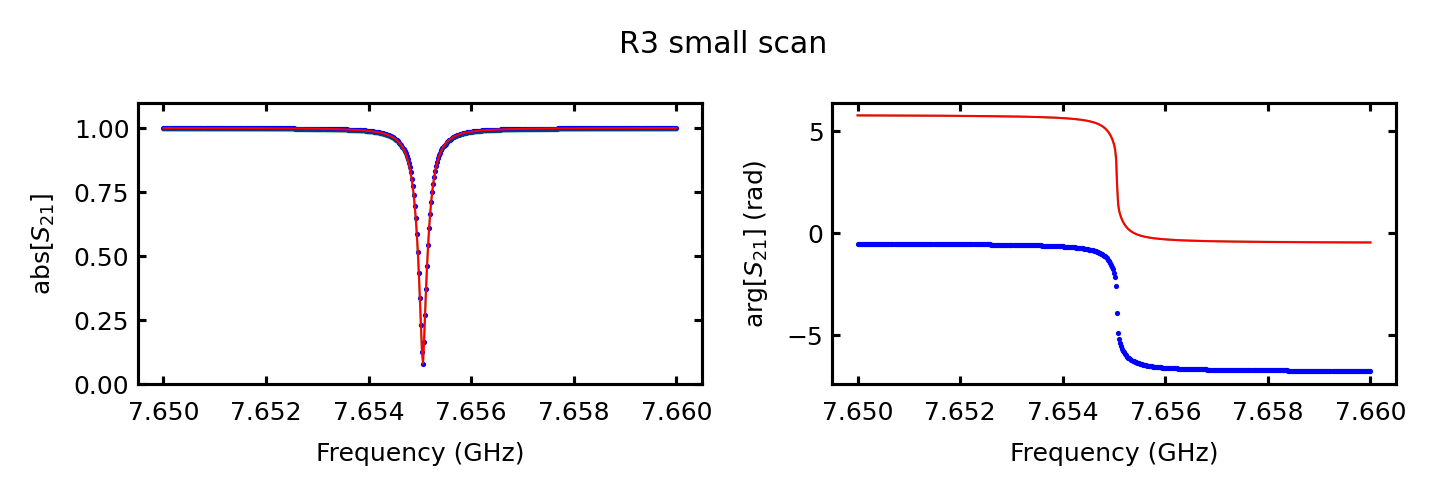

In [8]:
modify_dict = False # first check if everything is nicely fitted, then update the dictionary
use_no_fano_with_amp = True
plotting = True

resonances = small_vna_scan_analysis(dataset_smallscan, resonances, modify_dict, use_no_fano_with_amp, plotting=plotting)